In [2]:
import numpy as np
import scipy.sparse
import pandas as pd
pd.set_option("display.max_columns", None)
import time
import datetime
from sklearn import metrics
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix
import tensorflow as tf
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import tensorflow_transform as tft

from tqdm import tqdm
tqdm.pandas()

In [3]:
from google.cloud import bigquery
import gcsfs

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [4]:
def focal_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.75, gamma=3.0)


In [5]:
# Load the model
model_path = {}
model_path["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23824/serving_model_dir"
model_path["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23837/serving_model_dir"
model_path["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23951/serving_model_dir"
#model = tf.saved_model.load(model_path)

In [6]:
# Load the vocab
tags_list_dict = {}
tags_list_dict["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23819/transform_fn/assets/tags"
tags_list_dict["concat_both"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23835/transform_fn/assets/tags"
tags_list_dict["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23949/transform_fn/assets/tags"
fs = gcsfs.GCSFileSystem(project="res-nbcupea-dev-ds-sandbox-001")
for key, path in tags_list_dict.items():
    if path == "": continue
    with fs.open(path, "r") as fid:
        tags_list = fid.read().split("\n")
    tags_list = [tag for tag in tags_list if tag != ""]
    tags_list_dict[key] = tags_list
tags_list

['Movie',
 'eng',
 'spa',
 'Drama',
 'Episode',
 'Action & Adventure',
 'Comedy',
 'Documentary',
 'Thriller',
 'Local',
 'Horror',
 'Romance',
 'Comedy drama',
 "Children's/Family Entertainment",
 'Crime drama',
 'Fantasy',
 'Animated',
 'Mystery',
 'Science fiction',
 'Sports',
 'Reality',
 'Western',
 'Entertainment',
 'Special',
 'Romance comedy',
 'Music',
 'Sports non-event',
 'Biography',
 'Independent',
 'Holiday',
 'Crime',
 'Military & War',
 'Religion',
 'older teens (ages 15+)',
 'Musical',
 'History drama',
 'Documentary drama',
 'History',
 'Shopping',
 'Educational',
 'kids (ages 5-9)',
 'teens (ages 13-14)',
 'Talk',
 'Travel',
 'Public Affairs',
 'Gay and Lesbian',
 'Foreign',
 'Food',
 'Animals',
 'Nature',
 'tweens (ages 10-12)',
 'News',
 'Miniseries',
 'Teens',
 'Martial arts',
 'Science & Technology',
 'Anime',
 'Courtroom',
 'Health',
 'Musical comedy',
 'Sitcom',
 'Outdoors',
 'Interview',
 'Variety',
 'Home & Garden',
 'Fashion',
 'Christmas',
 'Soccer',
 'Wedd

# Inspect training data only

In [8]:
query = """SELECT ROW_NUMBER() OVER() row_number, program_title, LOWER(program_title) AS title, program_type, 
    program_longsynopsis AS synopsis, tags
FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.synopsis_dylan_150tag_with_tokens_and_keywords`
LIMIT 50000
"""

df_train = client.query(query).to_dataframe()
df_train

,row_number,program_title,title,program_type,synopsis,tags
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]"
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]"
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]"
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]"
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]"
...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]"
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]"
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]"
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]"


In [9]:
# translate tags back into multi-hot labels
def tags_to_index(tags, tags_list):
    col = np.array([tags_list.index(t) for t in tags], dtype=int)
    data = np.ones(len(col), dtype=int)
    row = np.zeros(len(col), dtype=int)
    return coo_matrix((data, (row, col)), shape=(1, len(tags_list))).A[0]

for key in model_path.keys():
    df_train[f"labels_{key}"] = df_train["tags"].progress_apply(lambda x: tags_to_index(x, tags_list_dict[key]))
df_train

100%|██████████| 50000/50000 [00:02<00:00, 17000.97it/s]


,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
# Make predictions
input_data = {"synopsis": df_train['synopsis'].values[:, None], 
              "title": df_train["title"].values[:, None],
 }
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
    
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_train[f"{key}_predicted"] = res
    # Temporarily save the results
    df_train.to_pickle("./scratch/explore_emd_07_train_predicted_values.pkl", compression="gzip")

df_train


Loading model: concat_before


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


Loading model: concat_both


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


Loading model: concat_after


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.8934669, 0.06632726, 0.95952654, 0.10030515...","[0.9070418, 0.06420858, 0.9550103, 0.09028389,...","[0.8253068, 0.12199429, 0.9541529, 0.5386213, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.8585604, 0.9404377, 0.04779131, 0.16191141,...","[0.8843223, 0.96550614, 0.043165814, 0.1640907...","[0.7824883, 0.9678829, 0.07003368, 0.56689805,..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0.81275606, 0.09641536, 0.96398777, 0.2381546...","[0.83753866, 0.10547957, 0.9587806, 0.20073584...","[0.7222696, 0.15386403, 0.96060145, 0.53743327..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.74899364, 0.90237004, 0.23544739, 0.1321258...","[0.7754286, 0.95119095, 0.22058079, 0.1296872,...","[0.59603435, 0.95589626, 0.21881342, 0.3977266..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.88985103, 0.07059304, 0.95813674, 0.6458064...","[0.86593497, 0.08458795, 0.958798, 0.6076865, ...","[0.8682472, 0.106376745, 0.95762813, 0.5779175..."
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9292693, 0.952023, 0.066356145, 0.3037845, ...","[0.910924, 0.95824075, 0.043018248, 0.3042492,...","[0.82836425, 0.94802564, 0.05877439, 0.530228,..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9270017, 0.066873714, 0.9442661, 0.99188846...","[0.9232281, 0.07477001, 0.9282448, 0.9857341, ...","[0.87275904, 0.09121653, 0.9521636, 0.5628774,..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9658848, 0.08058406, 0.9439644, 0.212059, 0...","[0.95162, 0.08855511, 0.94172895, 0.1954994, 0...","[0.8397483, 0.13116412, 0.95538336, 0.54482675..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0

In [11]:
df_train = pd.read_pickle("./scratch/explore_emd_07_train_predicted_values.pkl", compression="gzip")
df_train

,row_number,program_title,title,program_type,synopsis,tags,labels_concat_before,labels_concat_both,labels_concat_after,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,102971,Mad Holiday,mad holiday,Movie,El detective de una película resuelve un miste...,"[spa, Thriller, Comedy, Movie]","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.8934669, 0.06632726, 0.95952654, 0.10030515...","[0.9070418, 0.06420858, 0.9550103, 0.09028389,...","[0.8253068, 0.12199429, 0.9541529, 0.5386213, ..."
1,102972,Some Kind of Love,some kind of love,Movie,Artist and designer Yolanda Sonnabend and her ...,"[eng, Movie, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.8585604, 0.9404377, 0.04779131, 0.16191141,...","[0.8843223, 0.96550614, 0.043165814, 0.1640907...","[0.7824883, 0.9678829, 0.07003368, 0.56689805,..."
2,102973,Mantis Peligrosa,mantis peligrosa,Movie,Adaptada de la novela por Hubert de Monteilhet...,"[spa, Movie, Crime drama, Romance]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0.81275606, 0.09641536, 0.96398777, 0.2381546...","[0.83753866, 0.10547957, 0.9587806, 0.20073584...","[0.7222696, 0.15386403, 0.96060145, 0.53743327..."
3,102974,Shadow of the Holy Book,shadow of the holy book,Movie,International companies continue to do busines...,"[Movie, eng, Documentary]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.74899364, 0.90237004, 0.23544739, 0.1321258...","[0.7754286, 0.95119095, 0.22058079, 0.1296872,...","[0.59603435, 0.95589626, 0.21881342, 0.3977266..."
4,102975,Retrato Íntimo de una Dama,retrato íntimo de una dama,Movie,Basada en la obra de Henry James sobre una muj...,"[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.88985103, 0.07059304, 0.95813674, 0.6458064...","[0.86593497, 0.08458795, 0.958798, 0.6076865, ...","[0.8682472, 0.106376745, 0.95762813, 0.5779175..."
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,221707,The Gunfighter,the gunfighter,Movie,An unseen narrator reveals people's thoughts a...,"[Movie, Comedy, eng, Western]","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9292693, 0.952023, 0.066356145, 0.3037845, ...","[0.910924, 0.95824075, 0.043018248, 0.3042492,...","[0.82836425, 0.94802564, 0.05877439, 0.530228,..."
49996,221708,El perdón de la hija de nadie,el perdón de la hija de nadie,Movie,"Una joven pierde a su esposo y a sus hermanos,...","[spa, Drama, Movie]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9270017, 0.066873714, 0.9442661, 0.99188846...","[0.9232281, 0.07477001, 0.9282448, 0.9857341, ...","[0.87275904, 0.09121653, 0.9521636, 0.5628774,..."
49997,221709,Y Dios Dijo a Cain,y dios dijo a cain,Movie,Un hombre acusado injustamente de robo y homic...,"[Western, Movie, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9658848, 0.08058406, 0.9439644, 0.212059, 0...","[0.95162, 0.08855511, 0.94172895, 0.1954994, 0...","[0.8397483, 0.13116412, 0.95538336, 0.54482675..."
49998,221710,S Club 7: In Hollywood,s club 7: in hollywood,Episode,The humorous exploits of a British pop group i...,"[Drama, Music, eng, Sitcom, Episode]","[0, 1, 0, 1, 1, 0, 0, 0

In [12]:
## Binary classifier precision and recall ROC
classifier_metrics = {"concat_before": {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                      "concat_both":   {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                      "concat_after":   {"pr_auc": [], "roc_auc":[], "accuracy":[]},
                     }
labels = np.stack(df_train["labels_concat_before"]).astype(int)

# Looping over model
for key in classifier_metrics:
    predicted_score = np.stack(df_train[f"{key}_predicted"])
    predicted_binary = (predicted_score > 0.5).astype(int)
    # Looping over tags / vector
    for t in tqdm(range(labels.shape[1])):
        if np.all(labels[:, t] < 1E-3):
            accuracy, pr_auc, roc_auc = -1, -1, -1
        elif  np.all(labels[:, t]==1):
            accuracy, pr_auc, roc_auc = 10, 10, 10
        else:
            accuracy = (predicted_binary[:, t] == labels[:, t]).mean()
            pr_auc = metrics.average_precision_score(labels[:, t], predicted_score[:, t])
            roc_auc = metrics.roc_auc_score(labels[:, t], predicted_score[:, t])

        classifier_metrics[key]["accuracy"].append(accuracy)
        classifier_metrics[key]["pr_auc"].append(pr_auc)
        classifier_metrics[key]["roc_auc"].append(roc_auc)
    classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)



100%|██████████| 146/146 [00:03<00:00, 42.10it/s]


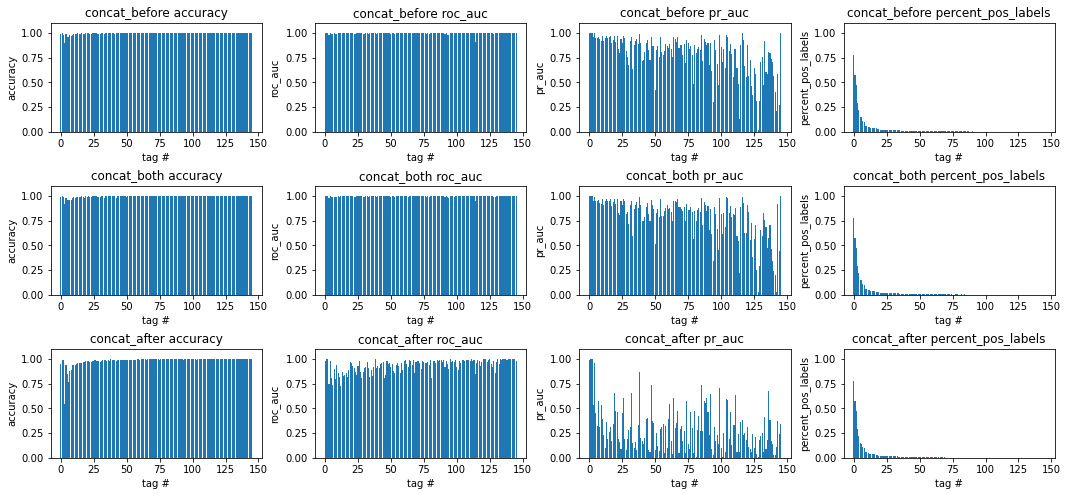

In [14]:
# Plot out the performance of classifier
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 4, figsize=(18, 8))

for j, key in enumerate(classifier_metrics.keys()):
    classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)
    for i, m in enumerate(["accuracy", "roc_auc", "pr_auc", "percent_pos_labels"]):
        ax = axs[j, i]
        ax.bar(np.arange(len(classifier_metrics[key][m])), classifier_metrics[key][m])
        ax.set_title(f"{key} {m}")
        ax.set_xlabel("tag #")
        ax.set_ylabel(m)
        ax.set_ylim(0, 1.1)
        
fig.subplots_adjust(wspace=0.25, hspace=0.5)


# Evaluation on the content-to-content recommendations

In [15]:
TITLES_QUERY_titles = """
    WITH titles_data AS (
        SELECT DISTINCT
            TitleDetails_title, 
            TitleType, 
            cid.content_ordinal_id,
            STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' ') as TitleDetails_longsynopsis,
        FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.ContentMetadataView` cmv
        LEFT JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentOrdinalId` cid
            ON LOWER(cmv.TitleDetails_title) = LOWER(cid.program_title)
        WHERE 
            TitleDetails_longsynopsis IS NOT NULL
            AND cid.content_ordinal_id IS NOT NULL
        GROUP BY 
            TitleDetails_title, 
            TitleType,
            cid.content_ordinal_id
        )
    SELECT TitleDetails_title, LOWER(TitleDetails_title) AS title, TitleType, content_ordinal_id, TitleDetails_longsynopsis, 
    FROM titles_data
"""
df_titles = client.query(TITLES_QUERY_titles) \
                        .to_dataframe() \
                        .drop_duplicates(subset=['TitleDetails_title']) \
                        .reset_index(drop=True)

    
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...
...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ..."


In [16]:
input_data = {"synopsis": df_titles['TitleDetails_longsynopsis'].values[:, None], 
              "title": df_titles['TitleDetails_longsynopsis'].values[:, None]}
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
   
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_titles[f"{key}_predicted"] = res
    # Temporarily save the results
    df_titles.to_pickle("./scratch/explore_emd_07_titles_predicted_values.pkl", compression="gzip")

df_titles


Loading model: concat_before


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:11<00:00,  4.00it/s]


Loading model: concat_both


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:11<00:00,  3.96it/s]


Loading model: concat_after


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:11<00:00,  3.98it/s]


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.82572275, 0.8620805, 0.20260306, 0.5442321,...","[0.8101622, 0.89531285, 0.14627147, 0.46928272...","[0.79734284, 0.8537501, 0.22907692, 0.417042, ..."
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.6745518, 0.97476304, 0.13806131, 0.5251195,...","[0.6965991, 0.97596323, 0.086428136, 0.4783468...","[0.71846527, 0.9820931, 0.14115505, 0.52690506..."
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.85344374, 0.96640146, 0.092651814, 0.677004...","[0.86821437, 0.95883435, 0.07281119, 0.6060896...","[0.83220744, 0.9642535, 0.11047073, 0.6072671,..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.74991864, 0.9447019, 0.24710113, 0.63034356...","[0.757171, 0.95129824, 0.18187079, 0.56932473,...","[0.79987866, 0.9553518, 0.2099137, 0.588048, 0..."
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.87171704, 0.9651357, 0.08164043, 0.6201653,...","[0.88818765, 0.9599676, 0.06208499, 0.56803215...","[0.87786466, 0.96064824, 0.09332347, 0.5901719..."
...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5145462, 0.9096455, 0.10418529, 0.33951396,...","[0.5480638, 0.91077423, 0.07880795, 0.32602242...","[0.51589143, 0.9128771, 0.103963204, 0.4957055..."
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.8116353, 0.9475964, 0.11782857, 0.57066345,...","[0.7899944, 0.95454454, 0.079050995, 0.5353836...","[0.80947286, 0.9389232, 0.13783263, 0.57168764..."
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...,"[0.74996185, 0.9209636, 0.22169153, 0.5933068,...","[0.77825755, 0.9172044, 0.19623227, 0.53398424...","[0.7303368, 0.9194153, 0.2909512, 0.54296315, ..."
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ...","[0.7916899, 0.8176312, 0.091527864, 0.44676372...","[0.8104488, 0.880476, 0.07214383, 0.4369234, 0...","[0.7665079, 0.87548953, 0.101962626, 0.3697132..."


In [58]:
tmp = np.stack(df_titles.loc[df_titles["TitleDetails_title"]=="Swedish Dicks", 
              ["concat_both_predicted", "concat_after_predicted"]].values[0], axis=0)
tmp[:, -32:]

array([[-0.06357988, -0.15831548, -0.6572555 ,  0.05929879, -0.22633435,
         0.16049764, -0.37717625,  0.43260008, -0.3761738 , -0.6857465 ,
         0.13117267,  0.40673238,  0.15836239, -0.15681073, -0.37827083,
         0.13951738,  0.07845896,  0.2780028 , -0.4711527 ,  0.1471614 ,
         0.49986675, -0.53750235,  0.07298823, -0.03765107, -0.18119648,
        -0.24827762, -0.02725092, -0.10304254, -0.31158414,  0.01724819,
         0.42881262, -0.73775566],
       [-0.06357988, -0.15831548, -0.6572555 ,  0.05929879, -0.22633435,
         0.16049764, -0.37717625,  0.43260008, -0.3761738 , -0.6857465 ,
         0.13117267,  0.40673238,  0.15836239, -0.15681073, -0.37827083,
         0.13951738,  0.07845896,  0.2780028 , -0.4711527 ,  0.1471614 ,
         0.49986675, -0.53750235,  0.07298823, -0.03765107, -0.18119648,
        -0.24827762, -0.02725092, -0.10304254, -0.31158414,  0.01724819,
         0.42881262, -0.73775566]], dtype=float32)

## Plot the embeddings of some titles

In [20]:
important_titles = ["The Office", "30 Rock", "Punky Brewster", "Parks and Recreation", "WWE Monday Night RAW", 
            "Yellowstone", "Saturday Night Live", "Law & Order: Special Victims Unit", 
            "Law & Order: Organized Crime", "Mr. Mercedes", "Happy Feet Two", "Zombie Tidal Wave"]

key_tags = ["eng", "spa",
            'preschoolers (ages 2-4)', 'kids (ages 5-9)', 'tweens (ages 10-12)','teens (ages 13-14)',
            'older teens (ages 15+)','not for kids',
            "Action & Adventure", "Comedy","Horror", "Children's/Family Entertainment", "Sports", 
            "Animated", "Holiday", "Crime", 'News', 'Reality', 'Music', 'Christmas','Food','Travel','Fantasy',
            'Science fiction','History',
           ]

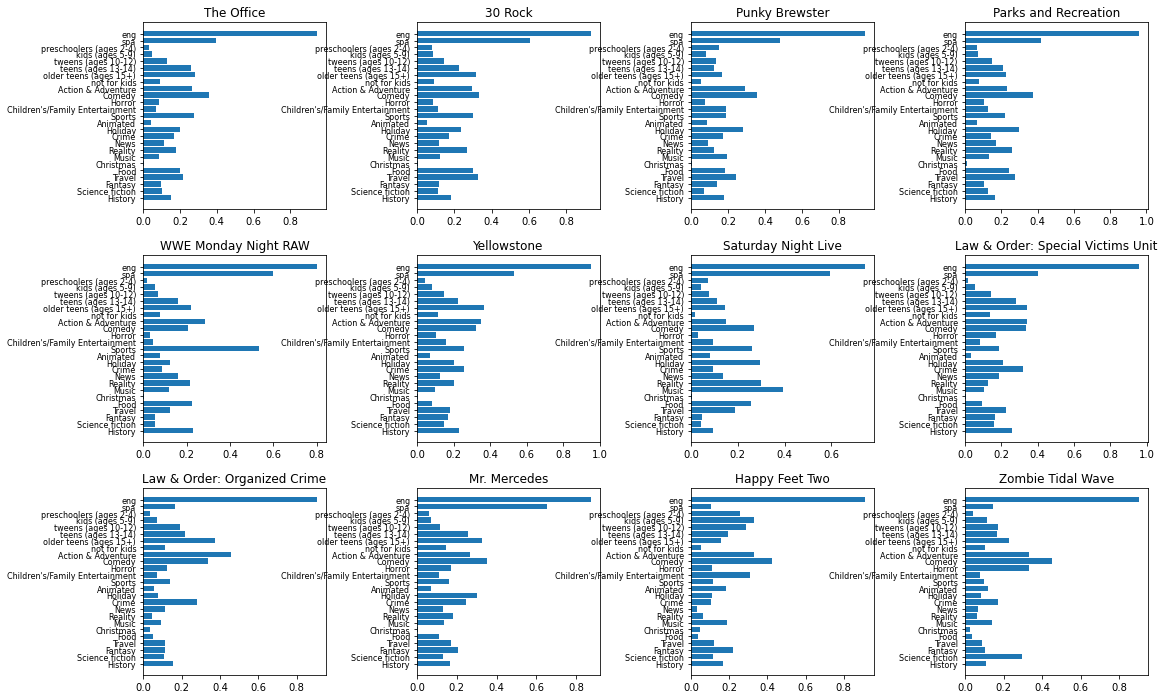

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_before"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

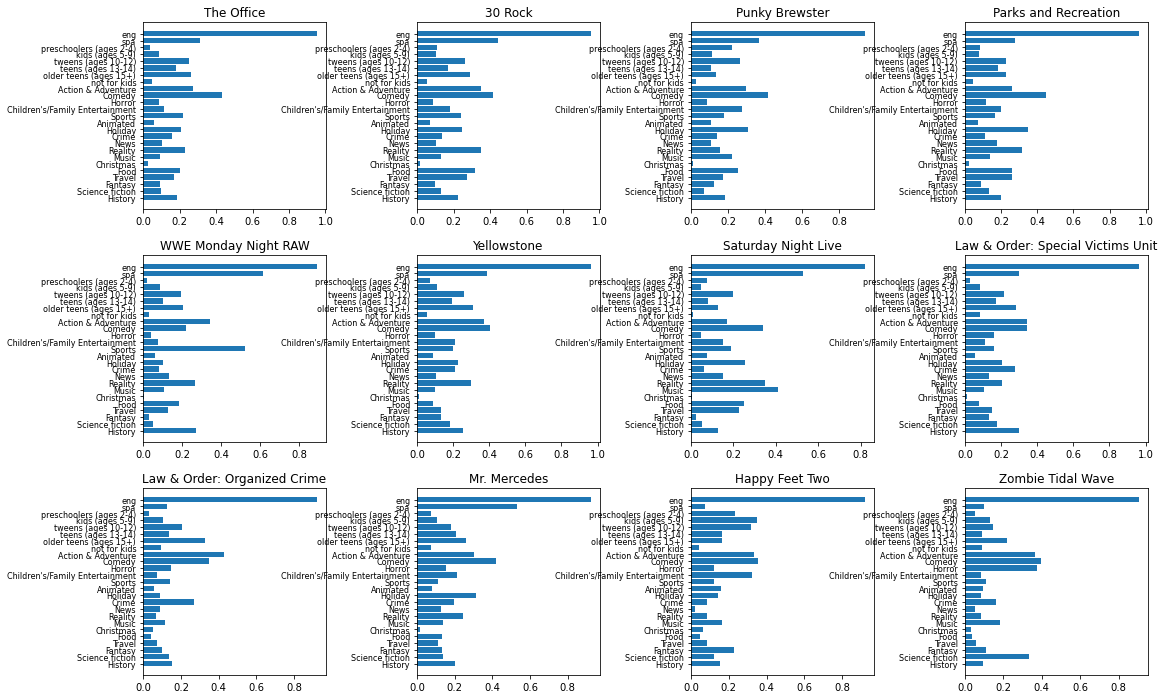

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_both"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

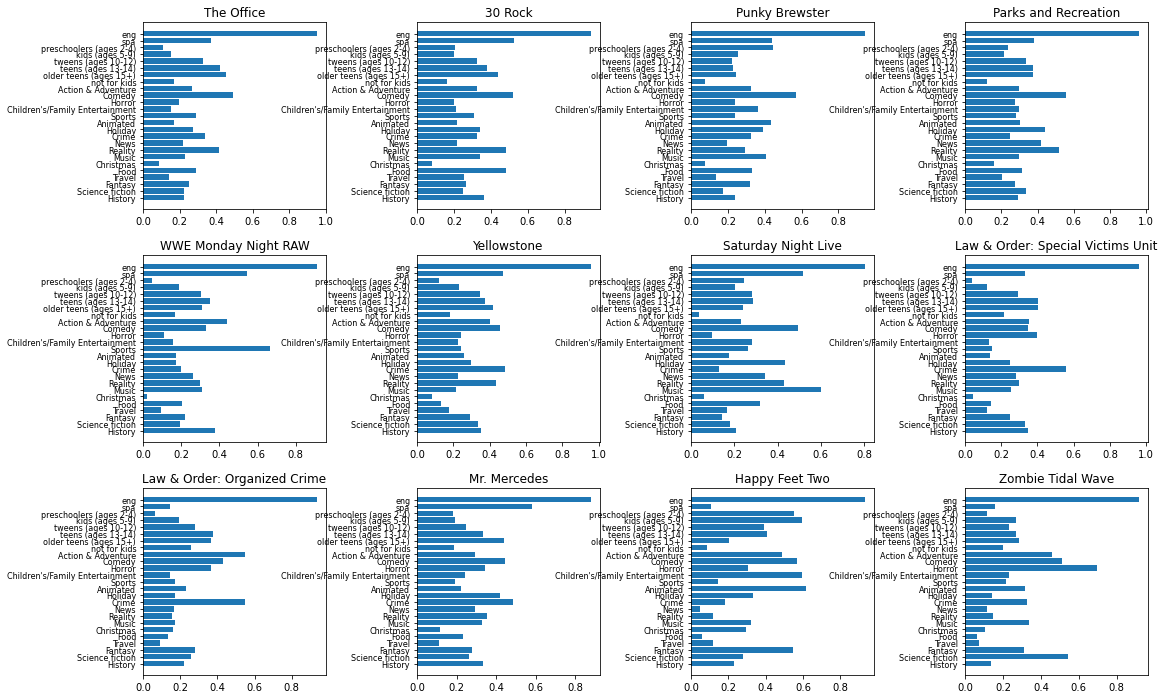

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(18, 12))
axs = axs.flatten()

key = "concat_after"
indices = [tags_list_dict[key].index(aa) for aa in key_tags]

for i, (ax, ti) in enumerate(zip(axs, important_titles)):
    values = np.take(df_titles.loc[df_titles["TitleDetails_title"] == ti, f"{key}_predicted"].values[0], 
                     indices)
    ax.barh(np.arange(25), values)
    ax.set_title(ti)
    ax.set_yticks(np.arange(25))
    ax.set_yticklabels(key_tags, fontsize=8)
    ax.invert_yaxis()

fig.subplots_adjust(wspace=0.5, hspace=0.25)

In [25]:
df_titles = pd.read_pickle("./scratch/explore_emd_07_titles_predicted_values.pkl", compression="gzip")
df_titles

,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.82572275, 0.8620805, 0.20260306, 0.5442321,...","[0.8101622, 0.89531285, 0.14627147, 0.46928272..."
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.6745518, 0.97476304, 0.13806131, 0.5251195,...","[0.6965991, 0.97596323, 0.086428136, 0.4783468..."
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.85344374, 0.96640146, 0.092651814, 0.677004...","[0.86821437, 0.95883435, 0.07281119, 0.6060896..."
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.74991864, 0.9447019, 0.24710113, 0.63034356...","[0.757171, 0.95129824, 0.18187079, 0.56932473,..."
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.87171704, 0.9651357, 0.08164043, 0.6201653,...","[0.88818765, 0.9599676, 0.06208499, 0.56803215..."
...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5145462, 0.9096455, 0.10418529, 0.33951396,...","[0.5480638, 0.91077423, 0.07880795, 0.32602242..."
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.8116353, 0.9475964, 0.11782857, 0.57066345,...","[0.7899944, 0.95454454, 0.079050995, 0.5353836..."
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...,"[0.74996185, 0.9209636, 0.22169153, 0.5933068,...","[0.77825755, 0.9172044, 0.19623227, 0.53398424..."
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Programme,1913,"Tara Lipinski,1998 Olympic gold medalist, and ...","[0.7916899, 0.8176312, 0.091527864, 0.44676372...","[0.8104488, 0.880476, 0.07214383, 0.4369234, 0..."


## Making Content to content recommendations

In [24]:
# Do the pairwise similarity
def cosine_sim(P):
    P = P / np.sqrt(np.sum(P**2, axis=1, keepdims=True))
    cos_sim_c2c = P @ P.T
    cos_sim_c2c = np.nan_to_num(cos_sim_c2c, nan=-1)
    return cos_sim_c2c

def kl_divergence(P):
    P = P / np.sum(P, axis=1, keepdims=True)
    H_p = -np.sum(P * np.log(P), axis=1, keepdims=True)
    H_p_q = -(P @ np.log(P.T))
    D_kl = H_p_q - H_p
    return D_kl

def js_divergence(P):
    D_kl = kl_divergence(P)
    return D_kl * 0.5 + D_kl.T * 0.5

similarity = {"cosine":{}}

for s in similarity:
    for key in model_path.keys():
        predicted = np.stack(df_titles[f"{key}_predicted"].values)
        similarity[s][key] = cosine_sim(predicted)
        
        # Slice out top 15 recommendations
        score = list(np.sort(similarity[s][key], axis=1)[:, ::-1][:, 1:(15+1)])
        sim_c2c_argsort = np.argsort(similarity[s][key], axis=1)[:, ::-1][:, 1:]
        titles = list(np.take(df_titles["TitleDetails_title"].values, sim_c2c_argsort[:, :15]))
        titles_type = list(np.take(df_titles["TitleType"].values, sim_c2c_argsort[:, :15]))
        synopsis = list(np.take(df_titles["TitleDetails_longsynopsis"].values, sim_c2c_argsort[:, :15]))
        content_id = list(np.take(df_titles["content_ordinal_id"].values, sim_c2c_argsort[:, :15]))
        dict_list = [{"TitleDetails_title": tt, "TitleType": ttype, "TitleDetails_longsynopsis": syn, "content_ordinal_id": cid, "score": sc} \
                     for tt, ttype, syn, cid, sc in zip(titles, titles_type, synopsis, content_id, score)]

        df_titles[f"{s}_{key}_top15"] = dict_list
        # Calculate a type match
        df_titles[f"{s}_{key}_type_match"] = (np.stack(titles_type) == df_titles["TitleType"][:, None]).mean(axis=1)
        
df_titles

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_both_top15,cosine_concat_both_type_match,cosine_concat_after_top15,cosine_concat_after_type_match
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.82572275, 0.8620805, 0.20260306, 0.5442321,...","[0.8101622, 0.89531285, 0.14627147, 0.46928272...","[0.79734284, 0.8537501, 0.22907692, 0.417042, ...",{'TitleDetails_title': ['Joel McHale: Live Fro...,1.000000,"{'TitleDetails_title': ['Brüno', 'Joel McHale:...",0.933333,{'TitleDetails_title': ['The Kentucky Fried Mo...,0.866667
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.6745518, 0.97476304, 0.13806131, 0.5251195,...","[0.6965991, 0.97596323, 0.086428136, 0.4783468...","[0.71846527, 0.9820931, 0.14115505, 0.52690506...","{'TitleDetails_title': ['Curse of Chucky', 'Zo...",1.000000,"{'TitleDetails_title': ['Brother's Keeper', 'P...",1.000000,"{'TitleDetails_title': ['Neds', 'Brother's Kee...",1.000000
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.85344374, 0.96640146, 0.092651814, 0.677004...","[0.86821437, 0.95883435, 0.07281119, 0.6060896...","[0.83220744, 0.9642535, 0.11047073, 0.6072671,...",{'TitleDetails_title': ['Live at the Foxes Den...,1.000000,{'TitleDetails_title': ['Live at the Foxes Den...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.74991864, 0.9447019, 0.24710113, 0.63034356...","[0.757171, 0.95129824, 0.18187079, 0.56932473,...","[0.79987866, 0.9553518, 0.2099137, 0.588048, 0...","{'TitleDetails_title': ['Primary Colors', 'Gun...",1.000000,"{'TitleDetails_title': ['Imitation of Life', '...",1.000000,"{'TitleDetails_title': ['Primary Colors', 'Ara...",0.933333
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.87171704, 0.9651357, 0.08164043, 0.6201653,...","[0.88818765, 0.9599676, 0.06208499, 0.56803215...","[0.87786466, 0.96064824, 0.09332347, 0.5901719...","{'TitleDetails_title': ['Once Fallen', 'Someth...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5145462, 0.9096455, 0.10418529, 0.33951396,...","[0.5480638, 0.91077423, 0.07880795, 0.32602242...","[0.51589143, 0.9128771, 0.103963204, 0.4957055...","{'TitleDetails_title': ['Gas Right', 'Closet O...",1.000000,{'TitleDetails_title': ['It's Not Halloween Wi...,0.933333,"{'TitleDetails_title': ['Moet & Chandon', 'Clo...",1.000000
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.8116353, 0.9475964, 0.11782857, 0.57066345,...","[0.7899944, 0.95454454, 0.079050995, 0.5353836...","[0.80947286, 0.9389232, 0.13783263, 0.57168764...",{'TitleDetails_title': ['Born on the Fourth of...,0.066667,"{'TitleDetails_title': ['Dial a Prayer', 'Emil...",0.200000,"{'TitleDetails_title': ['Emily & Tim', 'My Fri...",0.066667
2268,To All the Pineapples We've Loved Before,to all the pineapples we've loved before,Programme,1406,James Roday and Dulé Hill break down the top t...,"[0.74996185, 0.9209636, 0.22169153, 0.5933068,...","[0.77825755, 0.9172044, 0.19623227, 0.53398424...","[0.7303368, 0.9194153, 0.2909512, 0.54296315, ...",{'TitleDetails_title': ['To All the Pineapples...,0.133333,{'TitleDetails_title': ['To All the Pineapples...,0.133333,{'TitleDetails_title': ['To all the pineapples...,0.133333
2269,U.S. Figure Skating: 100th Anniversary Special,u.s. figure skating: 100th anniversary special,Progra

## Plotting out the distribution of cosine similarities

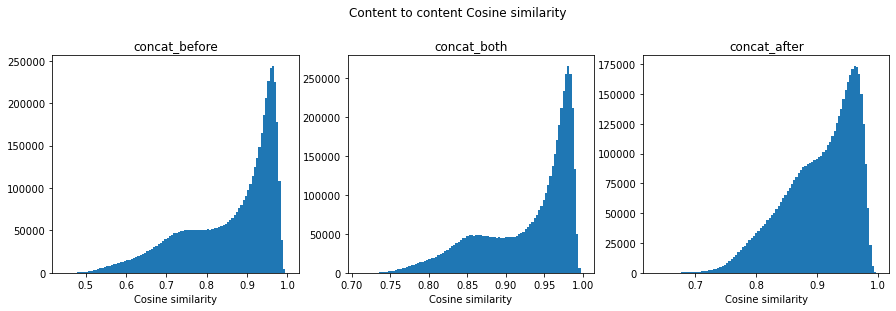

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, key in enumerate(model_path.keys()):
    ax = axs[i]
    ax.hist(np.sort(similarity["cosine"][key], axis=1)[:, ::-1][:, 1:].ravel(), bins=100) # remove cosine-sim with itself
    ax.set_xlabel("Cosine similarity")
    ax.set_title(key)
    
_ = fig.suptitle("Content to content Cosine similarity", y=1.05)

## Query some shows

In [27]:
# Do some quries
from IPython.display import display
def query_shows_c2c(df_titles, show_name, key="concat_after", sim_metric="cosine", show_res=True):
    pdf = df_titles.loc[df_titles["TitleDetails_title"]==show_name, :]
    pdf_query = pdf[["content_ordinal_id", "TitleDetails_title", "TitleType", "TitleDetails_longsynopsis"]]
    pdf_res = pd.DataFrame(pdf[f"{sim_metric}_{key}_top15"].values[0])
    if show_res:
        print("Query")
        display(pdf_query)
        print(f"Result: {sim_metric} {key}")
        display(pdf_res)
    
    return pdf_query, pdf_res
    

In [68]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_before")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.985319
1,The King of Queens,Programme,After learning that a wedding reception is fiv...,880,0.983861
2,Kourtney & Khloé Take Miami,Programme,Khloé's intimacy issues ruin her relationships...,491,0.983798
3,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.982815
4,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.982488
5,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.982096
6,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.981580
7,Saved by the Bell,Programme,Zack's (Mark-Paul Gosselaar) latest moneymakin...,695,0.979507
8,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.978843
9,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.978466


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.989841
1,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.985451
2,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.985364
3,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.984814
4,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.984292
5,Roger Ramjet,Programme,Roger has hallucinations; Roger and the Americ...,684,0.982826
6,Bad Girls Club: East Meets West,Programme,Susan quickly becomes labeled the house misfit...,126,0.982820
7,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.982656
8,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.982560
9,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.982542


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.984674
1,Postman Pat: Special Delivery Service,Programme,Pat's mission is to deliver a family of hibern...,1201,0.984216
2,Father Knows Best,Programme,The Anderson children enter an essay into a co...,1914,0.983853
3,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.982953
4,Dennis the Menace,Programme,Dennis eludes a baby sitter to go to a movie. ...,1836,0.982245
5,Chancer,Programme,Franklyn wants revenge. Douglas Motors calls o...,1676,0.981900
6,Psych,Programme,Shawn and Gus investigate a murder during the ...,652,0.981536
7,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.981266
8,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.981160
9,Briarpatch,Programme,Allegra and Singe investigate Packingtown; Jak...,1794,0.980816


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.985387
1,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.982683
2,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.981653
3,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.981502
4,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.981085
5,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.980705
6,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.980645
7,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.980221
8,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.980167
9,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.979391


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.990554
1,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.983011
2,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.982708
3,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.976328
4,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.974917
5,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.974541
6,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.972069
7,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.971005
8,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.970226
9,The 50 Greatest,Programme,WWE's greatest female Superstar of the modern ...,2297,0.966898


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.983472
1,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.983049
2,The Affair,Programme,Noah and Alison grow closer when they take a d...,1072,0.982648
3,Briarpatch,Programme,Allegra and Singe investigate Packingtown; Jak...,1794,0.981922
4,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.981644
5,Kenan,Programme,Kenan thinks he's adjusted to life as a busy s...,2200,0.981148
6,Treadstone,Programme,Superhuman assassins created during a covert o...,1571,0.980883
7,The Blacklist,Programme,As the task force investigates a kidnapping ex...,1073,0.980715
8,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.980552
9,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.980537


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.984974
1,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.968649
2,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.965953
3,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.964447
4,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.962468
5,Celebrity Game Face,Programme,Kelly Osbourne and Jack Osbourne; Loni Love an...,1749,0.960190
6,The Carol Burnett Show,Programme,Guests: Imogene Coca and Lainie Kazan. Guests:...,817,0.958474
7,Big Freedia: Queen of Bounce,Programme,Big Freedia dances on cars for her newest vide...,1597,0.957909
8,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.956600
9,Hollywood Game Night,Programme,"Celebrities John Legend, Chrissy Teigen, Jesse...",428,0.954687


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.985650
1,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.985140
2,Monk,Programme,Monk tries to learn the truth about his wife T...,573,0.985015
3,The Commish,Programme,Tony obsesses over finding the hijackers who s...,825,0.983943
4,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.983369
5,Case Histories,Programme,"Jackson Brodie, takes on a case of a mysteriou...",2022,0.982732
6,Killerpost,Programme,When a popular college freshman sends an omino...,485,0.982647
7,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.982316
8,Stingray,Programme,"Millions will die, unless Stingray can stop a ...",1684,0.981912
9,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.981776


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.986288
1,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.986108
2,Loaded,Movie,Three estranged friends from high school have ...,1607,0.985248
3,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.984787
4,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.984600
5,Missing,Movie,An American businessman (Jack Lemmon) joins hi...,570,0.984079
6,The Bourne Ultimatum,Movie,Jason Bourne (Matt Damon) continues his intern...,814,0.982466
7,Mortdecai,Movie,Armed with only his good looks and special cha...,2250,0.982338
8,American Gangster,Movie,A Harlem mobster (Denzel Washington) combines ...,1873,0.982301
9,John Wick 2,Movie,Legendary hit man John Wick comes out of retir...,2270,0.982206


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.986888
1,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.983306
2,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.982697
3,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.982650
4,The Commish,Programme,Tony obsesses over finding the hijackers who s...,825,0.982395
5,The Rockford Files,Programme,"A favor for a ""free spirit"" (Valerie Curtin) p...",922,0.981699
6,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.981276
7,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.981186
8,Bite Club,Programme,Zoe and Dan suspect that two brothers are resp...,173,0.980674
9,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.980641


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.980949
1,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.979781
2,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.977549
3,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.976639
4,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.976375
5,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.976289
6,A Dogwalker's Christmas Tale,Movie,A spoiled college student walks a developer's ...,1898,0.975321
7,The Life & Adventures of Santa Claus,Movie,"Fairies adopt an orphaned human baby, who grow...",1226,0.973805
8,A Winter Wedding,Movie,Hallie and Lucas plan the tropical beach weddi...,1613,0.972906
9,The Making of Hagrid's Magical Creatures Motor...,Programme,Hagrid's Magical Creatures Motorbike Adventure...,2100,0.972835


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_before


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.984474
1,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.982825
2,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.981136
3,The Invisible Man's Revenge,Movie,A criminal (Jon Hall) haunts his enemies' mans...,871,0.980175
4,Dementia 13,Movie,A mysterious masked killer terrorizes members ...,1557,0.980145
5,Half Light,Movie,A mystery writer (Demi Moore) tries to find th...,1453,0.979921
6,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.979532
7,Sins of Our Youth,Movie,Four teenagers accidentally kill a boy while t...,2210,0.979376
8,Tactical Force,Movie,Rival gangs trap members of a Los Angeles SWAT...,2019,0.978941
9,Dawn of the Dead,Movie,"A nurse (Sarah Polley), a policeman (Ving Rham...",1233,0.978746


In [69]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_both")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.991825
1,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.991479
2,The King of Queens,Programme,After learning that a wedding reception is fiv...,880,0.990409
3,Saved by the Bell,Programme,Zack's (Mark-Paul Gosselaar) latest moneymakin...,695,0.990283
4,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.989824
5,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.989634
6,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.989081
7,The Game,Programme,Jason and Malik's playing relationship is affe...,1076,0.989038
8,Intelligence,Programme,When the National Health Service's systems are...,1049,0.989004
9,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.988912


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.993314
1,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.993209
2,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.992966
3,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.992575
4,The Real Housewives of Potomac,Programme,Gizelle's lack of good manners puts her at odd...,1313,0.992005
5,Flipping Out,Programme,The countdown to the baby's due date leaves no...,360,0.991896
6,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.991840
7,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.991828
8,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.991796
9,Below Deck,Programme,Captain Lee and his returning crew are joined ...,149,0.991662


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.991607
1,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.991105
2,Psych,Programme,Shawn and Gus investigate a murder during the ...,652,0.990373
3,Little House on the Prairie,Programme,A farm boy (Mitch Vogel) takes Mr. Edward's ta...,1870,0.989831
4,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.989671
5,Postman Pat: Special Delivery Service,Programme,Pat's mission is to deliver a family of hibern...,1201,0.989477
6,My Life Me,Programme,Raffi's art show win hurtles Birch through the...,1146,0.989265
7,Briarpatch,Programme,Allegra and Singe investigate Packingtown; Jak...,1794,0.989042
8,The Munsters,Programme,Herman is forced to practice what he preaches ...,902,0.988897
9,Noddy in Toyland,Programme,Mr. Wobbly Man and Noddy offer to look after t...,1151,0.988837


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.991957
1,Mr. Robinson,Programme,Disgusted with Ben's sloppiness and lack of em...,1978,0.991701
2,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.990952
3,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.990896
4,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.990881
5,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.989891
6,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.989568
7,Pearson,Programme,Jessica tries to square a debt; Nick reels fro...,629,0.989141
8,Rob & Chyna,Programme,Rob feels life is on track; Chyna stops being ...,681,0.988984
9,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.988583


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.994718
1,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.990993
2,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.988269
3,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.987711
4,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.986421
5,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.984903
6,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.984892
7,American Ninja Warrior Junior,Programme,"All-star ninjas Barclay Stockett, Najee Richar...",90,0.984699
8,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.984026
9,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.980957


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.991452
1,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.991430
2,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.991155
3,The Affair,Programme,Noah and Alison grow closer when they take a d...,1072,0.990758
4,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.990666
5,Sacred Lies: The Singing Bones,Programme,Peter shares the end of the story with Elsie; ...,1225,0.990532
6,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.990515
7,Kenan,Programme,Kenan thinks he's adjusted to life as a busy s...,2200,0.990447
8,Homefront,Programme,Claire's time in Leysham has opened her eyes a...,1733,0.990395
9,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.990010


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.994270
1,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.988635
2,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.987271
3,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.982435
4,The At-Home Variety Show Featuring Seth MacFar...,Programme,"Act 1 -- Masterclass: Action Series, Acting in...",804,0.981785
5,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.980526
6,Big Freedia: Queen of Bounce,Programme,Big Freedia dances on cars for her newest vide...,1597,0.980144
7,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.980079
8,Hip-Hop Houdini,Programme,Magician Smoothini heads to rap star Becky G's...,2214,0.979645
9,Celebrity Game Face,Programme,Kelly Osbourne and Jack Osbourne; Loni Love an...,1749,0.979073


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,In Ice Cold Blood,Programme,A single mother becomes a murder victim while ...,458,0.991785
1,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.991785
2,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.991241
3,Killision Course,Programme,A path to murder ignites after Faye befriends ...,486,0.990047
4,Buried in the Backyard,Programme,After a homeowner randomly uncovers human rema...,199,0.989908
5,The Rockford Files,Programme,"A favor for a ""free spirit"" (Valerie Curtin) p...",922,0.989681
6,The Commish,Programme,Tony obsesses over finding the hijackers who s...,825,0.989411
7,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.989403
8,Case Histories,Programme,"Jackson Brodie, takes on a case of a mysteriou...",2022,0.989351
9,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.989308


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.995244
1,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.995210
2,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.994552
3,Marauders,Movie,"FBI agents (Christopher Meloni, Dave Bautista)...",541,0.994420
4,The Interpreter,Movie,A Secret Service agent (Sean Penn) is suspicio...,868,0.994342
5,Fast Five,Movie,"In Rio de Janeiro, ex-con Dom Torretto (Vin Di...",2266,0.994339
6,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.994033
7,Missing,Movie,An American businessman (Jack Lemmon) joins hi...,570,0.993899
8,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.993726
9,Nighthawks,Movie,Undercover New York detectives (Sylvester Stal...,1649,0.993699


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.992016
1,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.991477
2,The Boss: Streaming Edition,Programme,El Tigre wants to get out of San Pedro del Oro...,1890,0.991204
3,Chancer,Programme,Franklyn wants revenge. Douglas Motors calls o...,1676,0.990703
4,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.990468
5,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.990466
6,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.990209
7,Pearson,Programme,Jessica tries to square a debt; Nick reels fro...,629,0.989862
8,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.989285
9,Sacred Lies: The Singing Bones,Programme,Peter shares the end of the story with Elsie; ...,1225,0.989110


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.991773
1,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.990517
2,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.990247
3,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.989972
4,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.989526
5,A Dogwalker's Christmas Tale,Movie,A spoiled college student walks a developer's ...,1898,0.988836
6,Morphle,Programme,Little Mila turns playtime into fun and educat...,2337,0.987679
7,Tammy Tell Me True,Movie,A wholesome river girl (Sandra Dee) floats her...,795,0.987407
8,The Tale of Despereaux,Movie,"In the faraway kingdom of Dor, a misfit mouse ...",1601,0.987280
9,Casper's Scare School,Movie,Casper wants to learn how to be a hobgoblin bu...,1580,0.987199


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_both


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.993430
1,Faces in the Crowd,Movie,A serial killer closes in on a woman (Milla Jo...,1695,0.991285
2,The Invisible Man's Revenge,Movie,A criminal (Jon Hall) haunts his enemies' mans...,871,0.991121
3,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.990856
4,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.990819
5,Hold Your Breath,Movie,A group of college students learns that an old...,425,0.990520
6,Dementia 13,Movie,A mysterious masked killer terrorizes members ...,1557,0.990442
7,Tactical Force,Movie,Rival gangs trap members of a Los Angeles SWAT...,2019,0.990440
8,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.990348
9,Manhunter,Movie,An ex-FBI sleuth (William L. Petersen) returns...,539,0.990291


In [29]:
for ti in important_titles:
    _ = query_shows_c2c(df_titles, ti, key="concat_after")


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1857,1891,The Office,Programme,Michael tries to raise employee morale with a ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Vanderpump Rules,Programme,Stassi returns from Vegas to find that SUR has...,1315,0.985604
1,Cheers,Programme,Sam is in for a surprise when a sexy TV-commer...,228,0.984510
2,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.983978
3,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.983904
4,Kourtney & Khloé Take Miami,Programme,Khloé's intimacy issues ruin her relationships...,491,0.983327
5,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.983282
6,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.983262
7,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.982672
8,Chrisley Knows Best,Programme,Real life escapades of Atlanta-based self-made...,236,0.982538
9,Pearson,Programme,Jessica tries to square a debt; Nick reels fro...,629,0.982459


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1745,17,30 Rock,Programme,Jack tries to take back a drunken New Year's E...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Shahs of Sunset,Programme,Reality sets in for Reza as he faces the truth...,720,0.990278
1,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.988494
2,A.P. Bio,Programme,When Jack gets into a petty dispute with the s...,36,0.986602
3,Southern Charm Savannah,Programme,Lyle and Catherine remain on shaky ground; Hag...,758,0.986594
4,WAGS: Miami,Programme,Hencha goes ballistic when Faven sets up Astri...,993,0.986154
5,Southern Charm New Orleans,Programme,Reagan celebrates the grand opening of her jew...,757,0.985943
6,Ladies of London,Programme,Caroline and Sophie battle it out over family ...,496,0.985855
7,The Real Housewives of Dallas,Programme,Brandi adopts a baby boy; LeeAnne blames her e...,917,0.985747
8,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.985536
9,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.985305


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1851,656,Punky Brewster,Programme,Punky creates chaos at the restaurant after He...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The PJs,Programme,When Thurgood discovers a hidden penthouse apa...,2164,0.986340
1,Dennis the Menace,Programme,Dennis eludes a baby sitter to go to a movie. ...,1836,0.985573
2,The Munsters,Programme,Herman is forced to practice what he preaches ...,902,0.983025
3,The Goode Family,Programme,Helen's back goes out the day before the organ...,853,0.982254
4,My Life Me,Programme,Raffi's art show win hurtles Birch through the...,1146,0.982227
5,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.980803
6,Keeping Up With the Kardashians,Programme,An anniversary party for mom and dad; Kim appe...,1301,0.980744
7,Psych,Programme,Shawn and Gus investigate a murder during the ...,652,0.979636
8,Nina's World,Programme,When Nina discovers a lone flower growing in a...,1423,0.979483
9,Ming's Dynasty,Programme,Riesling must abandon his hip-hop dreams to sa...,2271,0.979360


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1981,626,Parks and Recreation,Programme,"Leslie and Ben start new jobs; Donna, April an..."


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Office: Superfan Episodes,Programme,"Dwight takes Ryan on his first sales call, sub...",1968,0.986701
1,Sunnyside,Programme,Garrett gives Diana some media training as she...,783,0.984926
2,Superstore,Programme,When Cloud 9 becomes an official polling place...,784,0.984885
3,The Real Housewives of New Jersey,Programme,Teresa manages her daughter's acting career wh...,1310,0.983990
4,Flipping Out,Programme,The countdown to the baby's due date leaves no...,360,0.983181
5,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.982922
6,Bethenny Ever After,Programme,Bethenny's business flourishes; Bethenny takes...,157,0.982778
7,Southern Charm New Orleans,Programme,Reagan celebrates the grand opening of her jew...,757,0.982527
8,Everybody Loves Raymond,Programme,Ray is jealous because he thinks his brother R...,330,0.982204
9,Father of the Pride,Programme,"Overworked and feeling stressed, Larry takes a...",341,0.982133


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2047,2301,WWE Monday Night RAW,Programme,Shawn Michaels vs. Marty Jannetty. Ahmed Johns...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.991114
1,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.983876
2,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.983280
3,WWE Friday Night SmackDown,Programme,King Corbin promises to humiliate Roman Reigns...,2292,0.982643
4,WWE NXT,Programme,"The NXT Championship is on the line, when Alei...",2341,0.982332
5,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.980463
6,WrestleMania Rewind,Programme,John Cena against The Big Show from WrestleMan...,1211,0.978053
7,WWE Ruthless Aggression,Programme,Relive the formation of Evolution and triumphs...,1216,0.975350
8,WWE The Bump,Programme,Bobby Lashley and WWE Women's Tag Team Champio...,2363,0.973800
9,The Titan Games,Programme,Olympic snowboarder Hannah Teter and UFC champ...,935,0.973287


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1797,1017,Yellowstone,Programme,Kayce settles into his new role at the ranch; ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.984240
1,Homefront,Programme,Claire's time in Leysham has opened her eyes a...,1733,0.983221
2,Swedish Dicks,Programme,When a movie star hires the detective agency t...,786,0.982731
3,Chicago P.D.,Programme,When one of Voight's friends is found passed o...,232,0.982542
4,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.981989
5,The Blacklist,Programme,As the task force investigates a kidnapping ex...,1073,0.981901
6,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.981892
7,Brooklyn Nine-Nine,Programme,While investigating a string of hotel robberie...,1299,0.981111
8,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...,1562,0.980721
9,Council of Dads,Programme,Robin tackles the fall holidays bravely but fe...,261,0.980625


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1582,693,Saturday Night Live,Programme,A compilation of skits salutes actor Dan Aykro...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,TV host RuPaul; Meghan Trainor talks and perfo...,936,0.988693
1,It's Showtime at the Apollo,Programme,Soul IV Real; Big Daddy Kane; comic Dugar. Ger...,2084,0.983544
2,The Kelly Clarkson Show,Programme,"Kelly's video ""Just Sing""; Sherri Shepherd and...",878,0.981679
3,Late Night With Seth Meyers,Programme,Actor John Cena; actress Gugu Mbatha-Raw; Bren...,503,0.976117
4,The At-Home Variety Show Featuring Seth MacFar...,Programme,"Act 1 -- Masterclass: Action Series, Acting in...",804,0.975257
5,The Carol Burnett Show,Programme,Guests: Imogene Coca and Lainie Kazan. Guests:...,817,0.973344
6,Little Big Shots,Programme,A singer who became an Internet sensation; a s...,1280,0.972251
7,Talk Stoop,Programme,"Celebrities, artists and influencers stop by t...",1197,0.970412
8,Bring the Funny,Programme,The open mic round continues for the second ni...,193,0.969798
9,America's Got Talent,Programme,Seven acts from the previous night's show will...,85,0.969049


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2125,506,Law & Order: Special Victims Unit,Programme,A college student becomes a target after her w...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,"Murder, She Wrote",Programme,Insurance investigator Dennis Stanton confront...,586,0.988949
1,Buried in the Backyard,Programme,After a homeowner randomly uncovers human rema...,199,0.988544
2,Murder for Hire,Programme,"After a divorce and a business failure, a veng...",585,0.988307
3,In Ice Cold Blood,Programme,A single mother becomes a murder victim while ...,458,0.987412
4,Law & Order: Criminal Intent,Programme,When the corpse of a high-profile hip-hop prod...,505,0.986922
5,Stingray,Programme,"Millions will die, unless Stingray can stop a ...",1684,0.986592
6,Killision Course,Programme,A path to murder ignites after Faye befriends ...,486,0.986237
7,Case Histories,Programme,"Jackson Brodie, takes on a case of a mysteriou...",2022,0.986190
8,Dateline,Programme,A soon-to-be bride is caught in the middle of ...,271,0.985611
9,Columbo,Programme,Bitter sibling competition for control of a fa...,252,0.985327


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
2119,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.990362
1,Scarface,Movie,"Despite warnings from crime boss Johnny Lovo, ...",705,0.990158
2,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.990005
3,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.989102
4,John Wick,Movie,New York City becomes the bullet-riddled playg...,2269,0.989005
5,1275 Days,Movie,"After a botched home invasion, 15-year-old Bla...",2075,0.988959
6,Casino Royale,Movie,"After receiving a license to kill, British age...",1815,0.988868
7,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.988464
8,Checkmate,Movie,The lives of six people collide during an elab...,227,0.988105
9,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.987842


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.988189
1,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.986030
2,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.984389
3,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.982749
4,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.982030
5,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.981888
6,Manifest,Programme,Ben forms an alliance with a student from Flig...,540,0.981509
7,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.981496
8,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.981091
9,Southern Charm Savannah,Programme,Lyle and Catherine remain on shaky ground; Hag...,758,0.981008


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1450,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.983960
1,Curious George,Movie,The Man in the Yellow Hat is on hand to help a...,266,0.982243
2,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.981893
3,"Monster High: Boo York, Boo York",Movie,Cleo is invited to the big city to attend a fa...,576,0.980074
4,The Life & Adventures of Santa Claus,Movie,"Fairies adopt an orphaned human baby, who grow...",1226,0.979622
5,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.979568
6,Curious George: Royal Monkey,Movie,"In a case of mistaken identity, George is swap...",1584,0.979462
7,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.979460
8,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.978198
9,The Making of Hagrid's Magical Creatures Motor...,Programme,Hagrid's Magical Creatures Motorbike Adventure...,2100,0.978050


Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1402,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.986968
1,Vampire in Vegas,Movie,An ancient vampire (Tony Todd) searches for a ...,2104,0.984629
2,Last Seen in Idaho,Movie,A woman awakens from a coma and begins experie...,2152,0.983522
3,Killer App,Movie,"When a hacker creates an ""antisocial"" networki...",2005,0.982939
4,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.982489
5,Tactical Force,Movie,Rival gangs trap members of a Los Angeles SWAT...,2019,0.982486
6,Cult of Chucky,Movie,"Chucky returns to terrorize his human victim, ...",1555,0.982271
7,The Invisible Man's Revenge,Movie,A criminal (Jon Hall) haunts his enemies' mans...,871,0.982200
8,Breakdown Lane,Movie,"After her car breaks down in the desert, a wom...",2039,0.982178
9,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.982107


In [72]:
_ = query_shows_c2c(df_titles, "Mr. Mercedes", key="concat_after")

Query


,content_ordinal_id,TitleDetails_title,TitleType,TitleDetails_longsynopsis
1895,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_after


,TitleDetails_title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.988189
1,Save Me,Programme,A police recording of a distressed emergency c...,1268,0.986030
2,Two and a Half Men,Programme,A near-death experience has an adverse effect ...,973,0.984389
3,Ray Donovan,Programme,Mickey and Van look for incriminating evidence...,1064,0.982749
4,Heroes,Programme,While facing the unexpected consequences of hi...,416,0.982030
5,CONNECTING...,Programme,"With Memorial Day around the corner, Garret ha...",1537,0.981888
6,Manifest,Programme,Ben forms an alliance with a student from Flig...,540,0.981509
7,Perfect Harmony,Programme,"Arthur deals with Jean's father, who attempts ...",632,0.981496
8,Zoey's Extraordinary Playlist,Programme,Zoey must decide whether or not to get involve...,1022,0.981091
9,Southern Charm Savannah,Programme,Lyle and Catherine remain on shaky ground; Hag...,758,0.981008


## Visualize embedded contents with TSNE

In [61]:
# Dimensionality reduce the embeddings
from sklearn.manifold import TSNE
def kl_distance(p, q):
    return np.sum(p * np.log((p+1E-12) / (q+1E-12)))

for key in model_path.keys():
    print(key)
    val = np.stack(df_titles[f"{key}_predicted"].values)
    tsne_xy = TSNE(n_components=2, metric="cosine", square_distances="legacy").fit_transform(val)
    df_titles[f"{key}_x"] = tsne_xy[:, 0]
    df_titles[f"{key}_y"] = tsne_xy[:, 1]
df_titles.to_pickle("./explore_emd_07_c2c_predicted_values-tsne.pkl")
df_titles

concat_before


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_both


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_after


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


,TitleDetails_title,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,concat_before_predicted,concat_both_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_both_top15,cosine_concat_both_type_match,cosine_concat_after_top15,cosine_concat_after_type_match,concat_before_x,concat_before_y,concat_both_x,concat_both_y,concat_after_x,concat_after_y
0,Man on the Moon,man on the moon,Movie,538,Milos Forman's film spotlights Andy Kaufman's ...,"[0.82572275, 0.8620805, 0.20260306, 0.5442321,...","[0.8101622, 0.89531285, 0.14627147, 0.46928272...","[0.79734284, 0.8537501, 0.22907692, 0.417042, ...",{'TitleDetails_title': ['Joel McHale: Live Fro...,1.000000,"{'TitleDetails_title': ['Brüno', 'Joel McHale:...",0.933333,{'TitleDetails_title': ['The Kentucky Fried Mo...,0.866667,-4.453685,-26.722670,15.340241,12.924276,-13.400740,-18.107977
1,Age of Dinosaurs,age of dinosaurs,Movie,52,A former firefighter fights to rescue his teen...,"[0.6745518, 0.97476304, 0.13806131, 0.5251195,...","[0.6965991, 0.97596323, 0.086428136, 0.4783468...","[0.71846527, 0.9820931, 0.14115505, 0.52690506...","{'TitleDetails_title': ['Curse of Chucky', 'Zo...",1.000000,"{'TitleDetails_title': ['Brother's Keeper', 'P...",1.000000,"{'TitleDetails_title': ['Neds', 'Brother's Kee...",1.000000,-8.708362,-2.408602,-22.067490,-0.365490,-6.954304,15.268892
2,The Big Lebowski,the big lebowski,Movie,1153,"Bowling buddies (Jeff Bridges, John Goodman) b...","[0.85344374, 0.96640146, 0.092651814, 0.677004...","[0.86821437, 0.95883435, 0.07281119, 0.6060896...","[0.83220744, 0.9642535, 0.11047073, 0.6072671,...",{'TitleDetails_title': ['Live at the Foxes Den...,1.000000,{'TitleDetails_title': ['Live at the Foxes Den...,1.000000,{'TitleDetails_title': ['Telling Lies in Ameri...,1.000000,2.112173,-25.105211,23.581362,-3.201848,-5.991690,-26.406605
3,The Front Page,the front page,Movie,849,The managing editor (Walter Matthau) of a 1920...,"[0.74991864, 0.9447019, 0.24710113, 0.63034356...","[0.757171, 0.95129824, 0.18187079, 0.56932473,...","[0.79987866, 0.9553518, 0.2099137, 0.588048, 0...","{'TitleDetails_title': ['Primary Colors', 'Gun...",1.000000,"{'TitleDetails_title': ['Imitation of Life', '...",1.000000,"{'TitleDetails_title': ['Primary Colors', 'Ara...",0.933333,13.261314,-7.134501,1.800204,-4.826156,-3.315084,4.569846
4,Middle Men,middle men,Movie,558,A Texas businessman (Luke Wilson) tries unsucc...,"[0.87171704, 0.9651357, 0.08164043, 0.6201653,...","[0.88818765, 0.9599676, 0.06208499, 0.56803215...","[0.87786466, 0.96064824, 0.09332347, 0.5901719...","{'TitleDetails_title': ['Once Fallen', 'Someth...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,"{'TitleDetails_title': ['Once Fallen', 'The To...",1.000000,29.374794,21.962744,6.794091,-37.561630,39.665981,-16.765308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Reagan Jeans,reagan jeans,Programme,1424,Will shrink by 5 percent.,"[0.5145462, 0.9096455, 0.10418529, 0.33951396,...","[0.5480638, 0.91077423, 0.07880795, 0.32602242...","[0.51589143, 0.9128771, 0.103963204, 0.4957055...","{'TitleDetails_title': ['Gas Right', 'Closet O...",1.000000,{'TitleDetails_title': ['It's Not Halloween Wi...,0.933333,"{'TitleDetails_title': ['Moet & Chandon', 'Clo...",1.000000,-27.226648,-3.786524,15.427880,35.560722,-22.754774,15.396341
2267,Keira Knightley's early protest,keira knightley's early protest,Programme,1380,Keira Knightley discusses the collision betwee...,"[0.8116353, 0.9475964, 0.11782857, 0.57066345,...","[0.7899944, 0.95454454, 0.079050995, 0.5353836...","[0.80947286, 0.9389232, 0.13783263, 0.57168764...",{'TitleDetails_title': ['Born on the Fourth of...,0.066667,"{'TitleDetails_title': ['Dial a Prayer', 'Emil...",0.200000,"{'TitleDetails_title': ['Emily & Tim', 'My Fri...",0.066667,-4.404478,-16.226068,9.117455,11.971776,-10.374728,-5.372737
2268,To All the Pineapples We've Loved Before,to 

In [65]:
from bokeh.io import output_notebook, output_file, show, save, reset_output, export_png, export_svg
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Circle, MultiLine, Div
from bokeh.layouts import gridplot, row, column
import itertools

output_notebook()

def plot_queries_graph(df_titles, show_name, key="concat_after", metric="cosine", **kwargs):
    p1 = figure(title=f"{show_name} {key}", plot_width=300, plot_height=250,
              tools=["hover", "pan", "box_zoom", "reset"], tooltips=[("", "@TitleDetails_title")], 
                toolbar_location="right", **kwargs)    
    index = np.zeros(df_titles.shape[0], dtype=int)
    pdf = pd.DataFrame(df_titles.loc[df_titles["TitleDetails_title"]==show_name, f"{metric}_{key}_top15"].values[0])
    index[df_titles["content_ordinal_id"].isin(pdf["content_ordinal_id"])] = 1 # query
    index[df_titles["TitleDetails_title"]==show_name] = 2 # title

    xxyy = [f"{key}_x", f"{key}_y"]
    pdf = df_titles[xxyy+ ["TitleDetails_title"]].iloc[index==0]\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==1])\
        .append(df_titles[xxyy+["TitleDetails_title"]].iloc[index==2])
    c0, c1, c2 = np.sum(index==0), np.sum(index==1), np.sum(index==2)
    pdf["colors"] = ["#1f77b4"] * c0 + ["#ff7f0e"] * c1 + ["red"] * c2
    pdf["alpha"] =  [0.3] * c0 + [1] * c1 + [1] * c2
    
    p1.scatter(*xxyy, source=pdf, color="colors", alpha="alpha") # all dots
    
    return p1


Loading BokehJS ...

In [67]:
plot_list = []
output_file(filename="./scratch/embed_07_examples_cosine_tsne_space.html")

for j, key in enumerate(model_path.keys()):
    for i, show_name in enumerate(["The Office", "Yellowstone", "Mr. Mercedes", "30 Rock",
                           "Law & Order: Organized Crime"]):
        pp = plot_queries_graph(df_titles, show_name=show_name, key=key)
        plot_list.append(pp)
grid = gridplot(plot_list, ncols=i+1)
show(grid)
save(grid)

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/scratch/embed_07_examples_cosine_tsne_space.html'

In [70]:
export_png(grid, filename="./scratch/embed_07_examples_cosine_tsne_space.png")

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/embed_07_examples_cosine_tsne_space.png'

<img src='./scratch/embed_07_examples_cosine_tsne_space.png'>